# Import Module

In [11]:
from dqn_agent import DQNAgent
from nn_model import NeuralNetwork
from memory import ExperienceReplayMemory
from environment import SingleStockEnv
from scaler_state import get_scaler
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import torch
import numpy as np
import plotly.graph_objects as go
import pyfolio as pf
import yfinance as yf
import empyrical
from tqdm.notebook import tqdm 
%matplotlib inline

# Stock Data

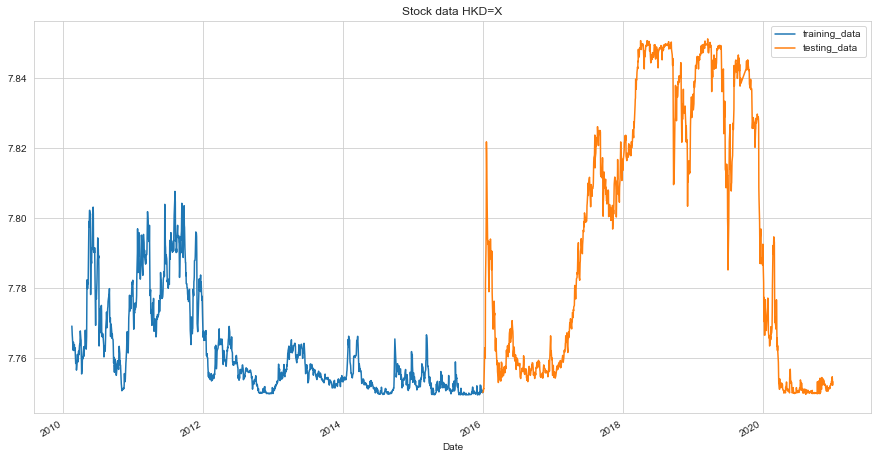

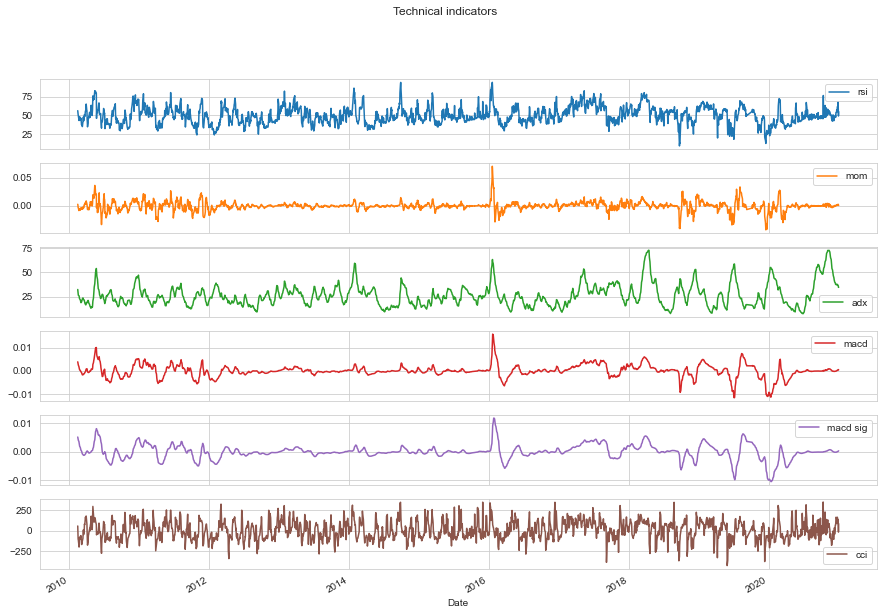

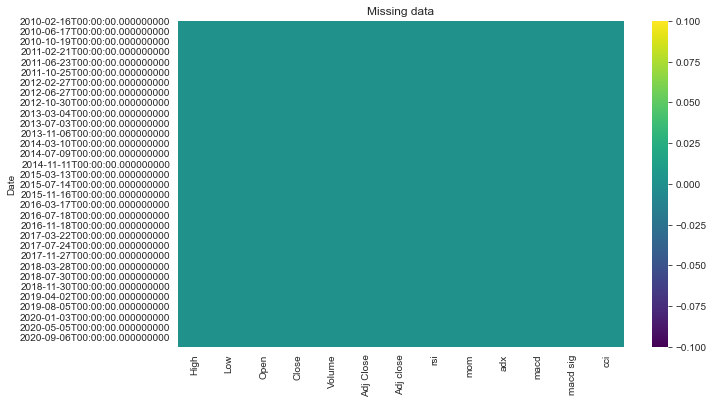

In [12]:
stock_name = 'hkd=X'.upper()
stock_data = web.DataReader(stock_name, 'yahoo', '2010-01-01', '2021-01-01')
stock_data['Adj close'] = stock_data['Close']
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data['cci'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.loc[:'2016-01-01']
test_data = stock_data.loc['2016-01-01':]

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()

In [13]:
len(train_data)

1531

# Config

In [14]:
num_episodes = 300
capital = 10000
position = 200
train_env = SingleStockEnv(train_data, capital, position)
state_size = train_env.state_dim
action_size = len(train_env.action_space)
agent = DQNAgent(input_sz=state_size, action_sz=action_size, discount_factor=0.9, ticker=stock_name)
scaler = get_scaler(train_env)

# Training

Training Model


  0%|          | 0/300 [00:00<?, ?it/s]

Episode:   15/300
Begin portfolio value: 10000.00
End portfolio value:    9974.88
Since: 1531 days
Return -0.25 %
Epsilon: 0.00100
Sell: 422, Buy: 426
Reward:   -25.12
Mean Squared Error Loss:   0.1920

Episode:   30/300
Begin portfolio value: 10000.00
End portfolio value:   10002.91
Since: 1531 days
Return 0.03 %
Epsilon: 0.00100
Sell: 444, Buy: 449
Reward:     2.91
Mean Squared Error Loss:   0.1201

Episode:   45/300
Begin portfolio value: 10000.00
End portfolio value:    9957.91
Since: 1531 days
Return -0.42 %
Epsilon: 0.00100
Sell: 429, Buy: 432
Reward:   -42.09
Mean Squared Error Loss:   0.2258

Episode:   60/300
Begin portfolio value: 10000.00
End portfolio value:    9987.81
Since: 1531 days
Return -0.12 %
Epsilon: 0.00100
Sell: 433, Buy: 439
Reward:   -12.19
Mean Squared Error Loss:   0.1498

Episode:   75/300
Begin portfolio value: 10000.00
End portfolio value:    9964.78
Since: 1531 days
Return -0.35 %
Epsilon: 0.00100
Sell: 436, Buy: 436
Reward:   -35.22
Mean Squared Error Lo

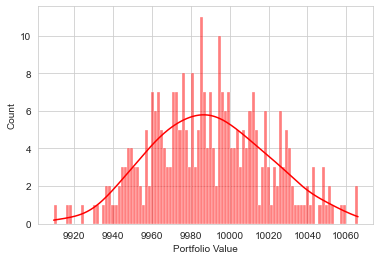

In [15]:
#train

print('Training Model')
portfolio_value = []
reward = []
total_reward = np.zeros(num_episodes)
for e in tqdm(range(num_episodes)):
 
    last_state = train_env.reset()
    last_reward = 0
    done = False
    scores = []
    while not done:
        last_state = scaler.transform([last_state])
        action = agent.update(last_reward, last_state)
        scores.append(agent.score())
        last_state, last_reward, done, info = train_env.step(action) 
        total_reward[e] += last_reward
    
    if (e+1) % (num_episodes/20) == 0:     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f'Since: {len(train_data)} days')
        print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
        print(f"Epsilon: {agent.save_epsilon[-1]:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Reward: {total_reward[e]:8.2f}')
        print(f"Mean Squared Error Loss: {agent.losses[-1]:8.4f}")
        print('=======================================================================')
        print()
    
    portfolio_value.append(info['portfolio_value'][-1]) 
    
       
agent.save()
losses = agent.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
sns.histplot(portfolio_value, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

# Loss

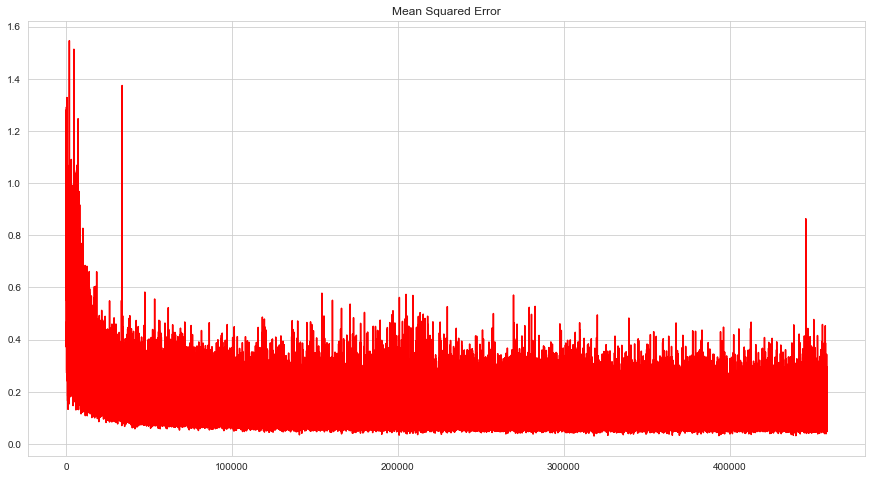

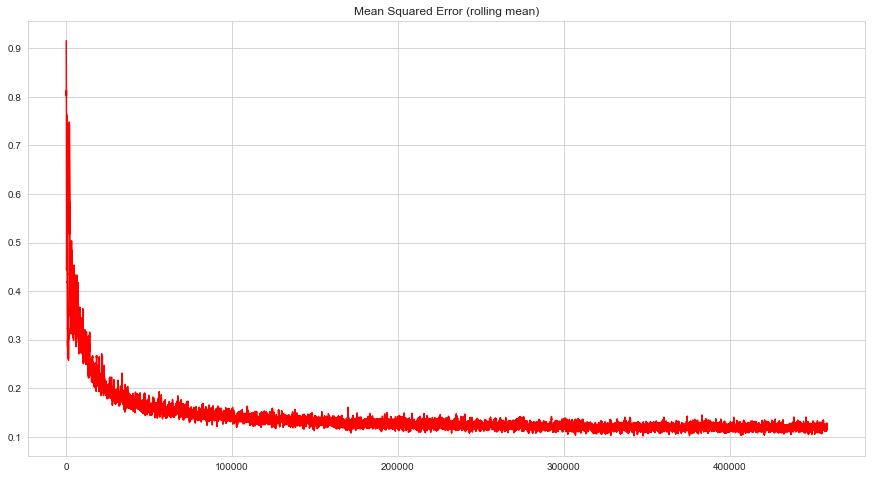

In [16]:
pd.Series(losses).plot(figsize=(15,8), c='r');
plt.title('Mean Squared Error');
plt.show()
pd.Series(losses).rolling(100).mean().plot(figsize=(15,8), c='r');
plt.title('Mean Squared Error (rolling mean)');

# Score

<AxesSubplot:>

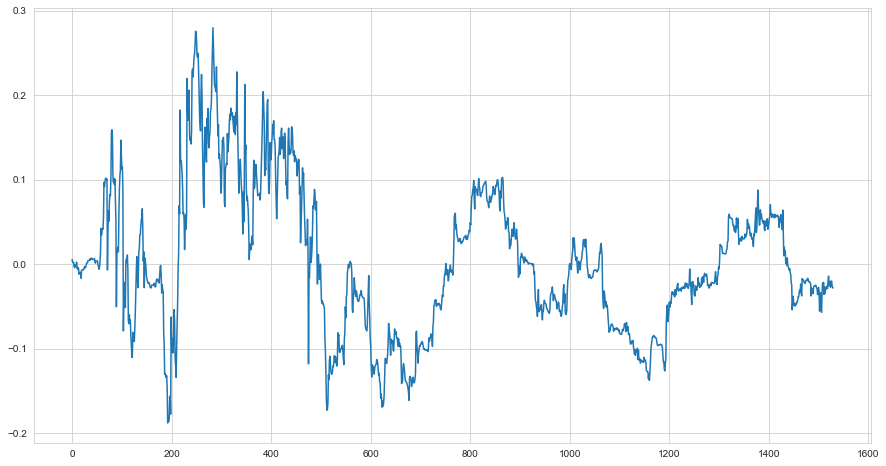

In [17]:
pd.Series(scores).plot(figsize=(15,8))

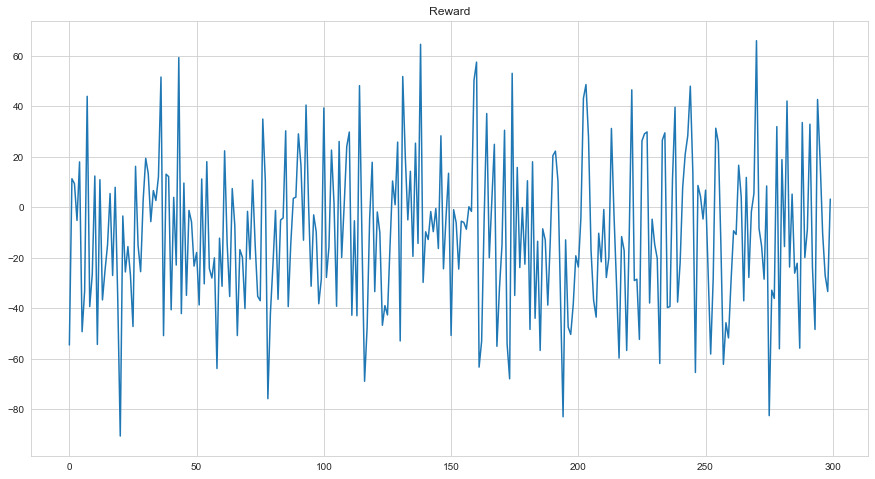

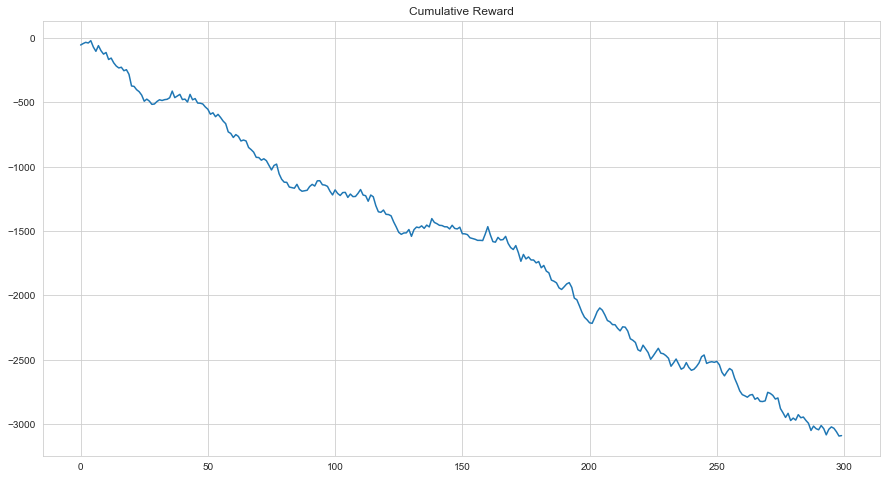

In [18]:
plt.figure(figsize=(15,8));
plt.plot(total_reward);
plt.title('Reward');
plt.show()
pd.Series(total_reward).cumsum().plot(figsize=(15,8));
plt.title('Cumulative Reward');

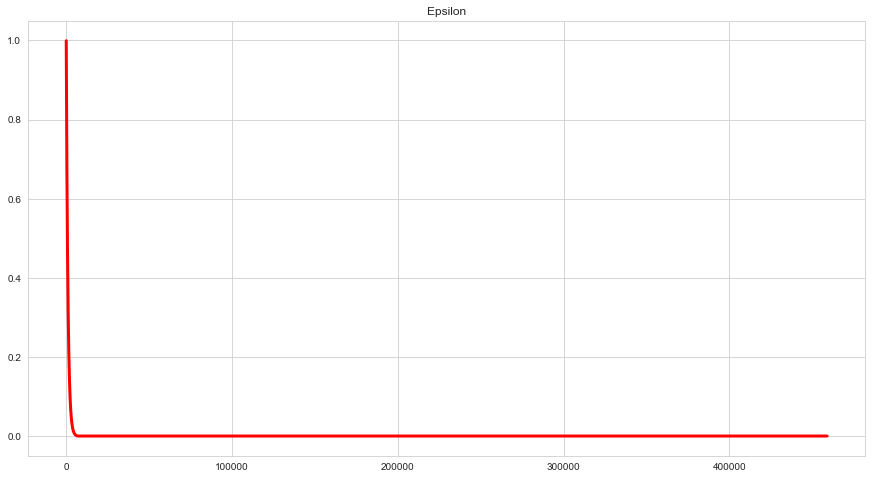

In [19]:
plt.figure(figsize=(15,8))
plt.plot(agent.save_epsilon, lw=3, c='r');plt.title('Epsilon');

# Testing

loading state dict form HKD=X
Completed!
Testing Model



Start: 2016-01-01 00:00:00  End: 2021-01-01 00:00:00
Since: 1283 days
Begin portfolio value: 10000.00
End portfolio value:    9991.08
Return -0.09 %
Sell: 20 times, Buy: 20 times


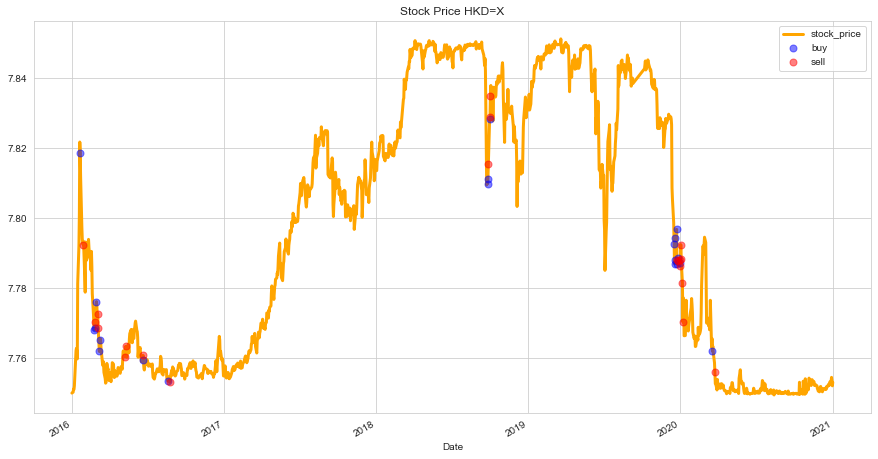

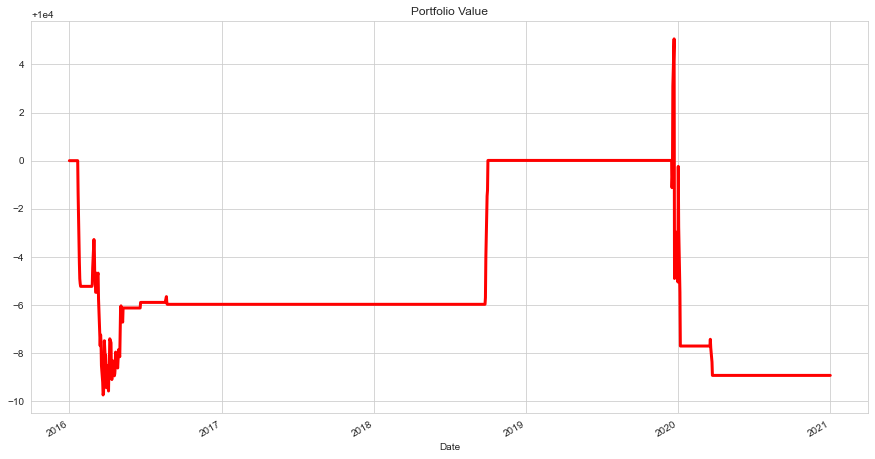

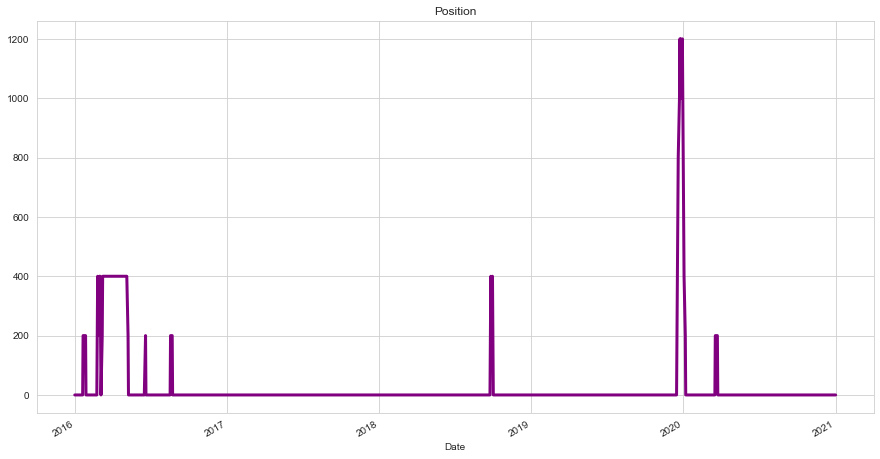

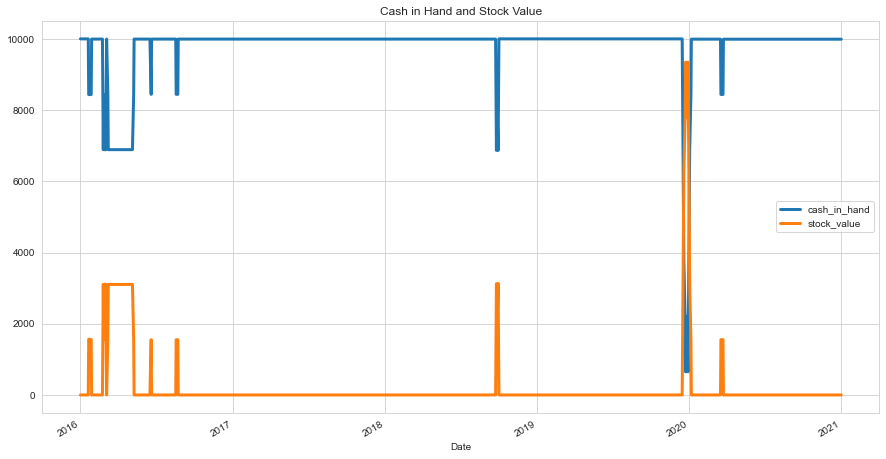

In [20]:
test_env = SingleStockEnv(test_data, capital, position)
state_size = test_env.state_dim
action_size = len(test_env.action_space)
agent = DQNAgent(state_size, action_size,0.9, ticker=stock_name)

last_state = test_env.reset()
last_reward = 0
done = False
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.model(last_state).argmax().item()
    last_state, last_reward, done, info = test_env.step(action)


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(15,8), c='orange', lw='3');
result['marker_buy'].plot(style='o', ms=7, label='buy', c='b', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['portfolio_value'].plot(figsize=(15,8), c='r', lw=3);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(15,8), c='purple', lw=3);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(15,8), lw=3);
plt.title('Cash in Hand and Stock Value');
plt.show()

# Performance Measurement - KPIs

In [21]:
import numpy as np
import datetime as dt

bn = web.DataReader('usd', 'yahoo', '2016-01-01', '2021-01-01')

def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/365
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(365)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr


print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result)*100:.2f} %')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result)*-100:.2f} %')
print(f'Calmar ratio: {calmer(result):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Benchmark')
print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(bn):.4f}')
print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(bn)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Adj close')
print(f'Compound Annual Growth Rate (Adj close): {CAGR(test_data)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(test_data):.4f}')
print(f'shape ratio: {sharpe(test_data, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(test_data)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(test_data):.4f}')

Stock name: HKD=X
Start: 2016-01-01 00:00:00  End: 2021-01-01 00:00:00
Compound Annual Growth Rate: -0.03 %
Volatility: 0.0008
shape ratio: -14.4166
Maximun drawdown: -0.14 %
Calmar ratio: -0.1817
-----------------------------------------------------------
Comparing with Benchmark
Compound Annual Growth Rate (benchmark): 78.36 %
Volatility (benchmark): 0.7129
shape ratio: 1.0838
Maximun drawdown: -61.45 %
Calmar ratio (benchmark): 1.2751
-----------------------------------------------------------
Comparing with Adj close
Compound Annual Growth Rate (Adj close): 0.01 %
Volatility (benchmark): 0.0073
shape ratio: -1.4816
Maximun drawdown: -1.29 %
Calmar ratio (benchmark): 0.0088


In [22]:
bt_returns = result['portfolio_value'].pct_change()
bm_returns = bn['Close'].pct_change()
price = test_data['Adj Close'].pct_change()

In [27]:
# plt.figure(figsize=(15,10));
# plt.subplot(2,1,1);
# pf.plotting.plot_rolling_returns(bt_returns, bm_returns);
# plt.title('Compare with Benchmark');

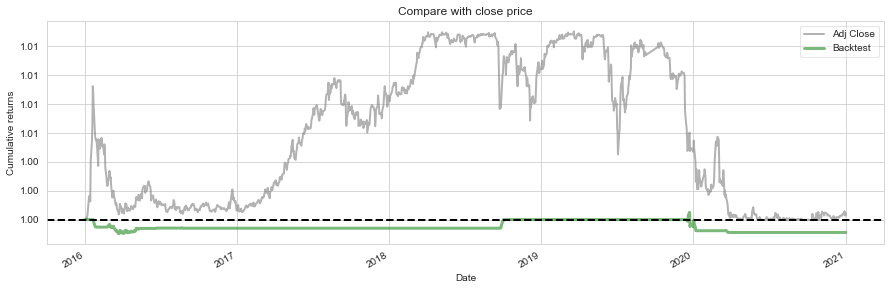

In [23]:
plt.figure(figsize=(15,10));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');

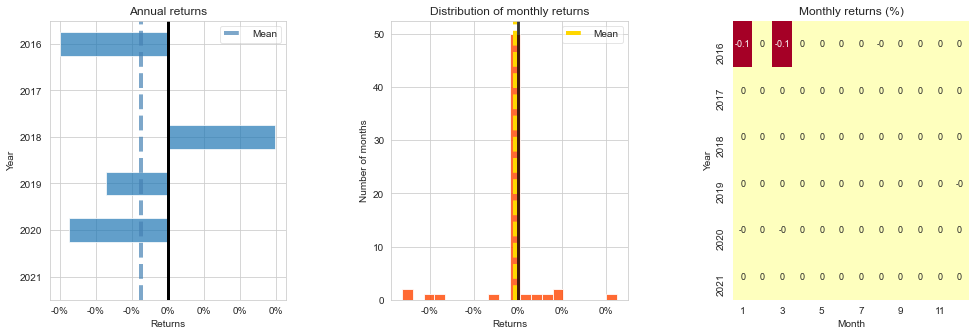

In [24]:
fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(15,5)

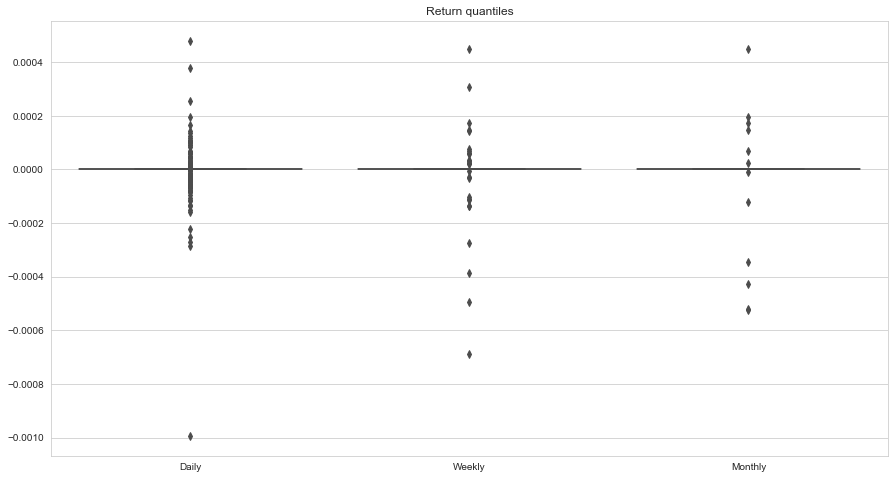

In [25]:
plt.figure(figsize=(15,8))
pf.plot_return_quantiles(bt_returns);

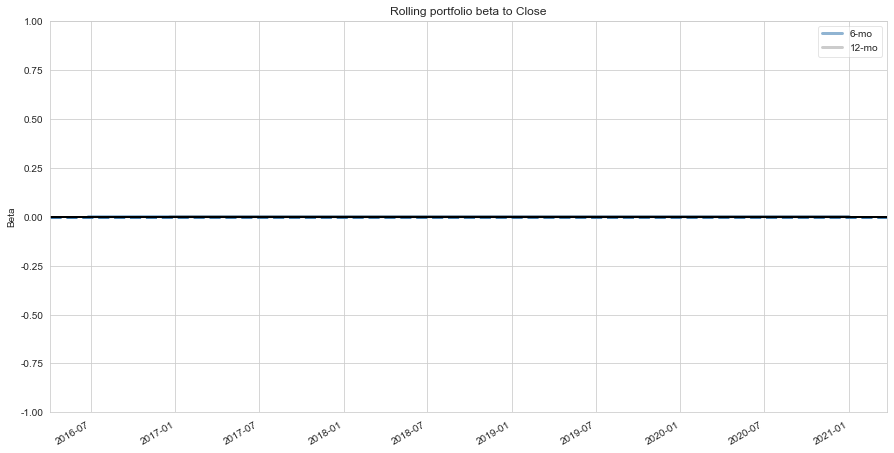

In [26]:
plt.figure(figsize=(15,8))
pf.plot_rolling_beta(bt_returns, bm_returns);

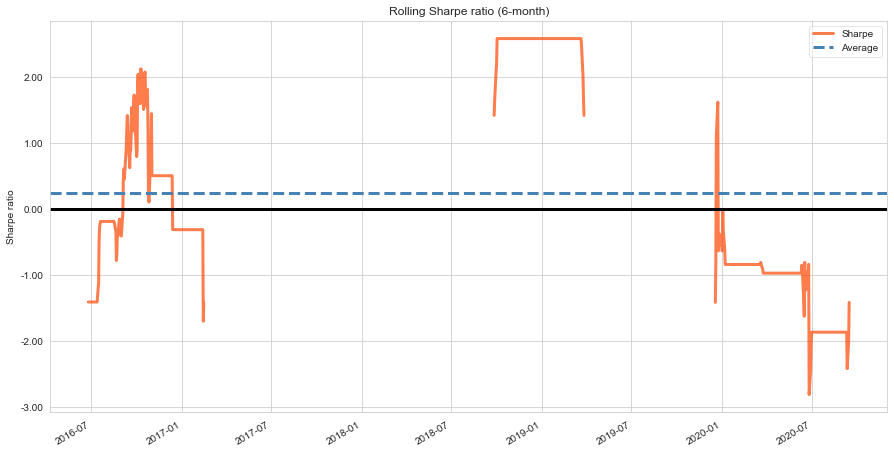

In [27]:
plt.figure(figsize=(15,8))
pf.plot_rolling_sharpe(bt_returns);

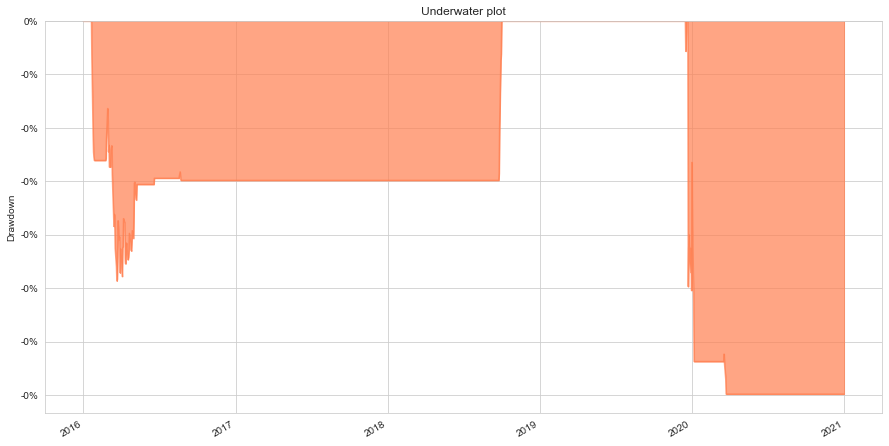

In [28]:
plt.figure(figsize=(15,8))
pf.plot_drawdown_underwater(bt_returns);